## **DATA COLLECTION**

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
!mkdir -p ../data/raw
!kaggle datasets download rohitgrewal/electricity-demand-data-dsl -p ../data/raw
!unzip -o ../data/raw/electricity-demand-data-dsl.zip -d ../data/raw
!rm ../data/raw/electricity-demand-data-dsl.zip

Dataset URL: https://www.kaggle.com/datasets/rohitgrewal/electricity-demand-data-dsl
License(s): DbCL-1.0
  0%|                                                | 0.00/945k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 945k/945k [00:00<00:00, 381MB/s]
Archive:  ../data/raw/electricity-demand-data-dsl.zip
  inflating: ../data/raw/python machine learning model xgboost - electricity demand dataset.csv  


## **EDA**

In [3]:
import pandas as pd
data = pd.read_csv(r"/home/mtng/projects/FORECASTING-ENGINE/data/raw/python machine learning model xgboost - electricity demand dataset.csv")

In [4]:
data.head(3)

,Timestamp,hour,dayofweek,month,year,dayofyear,Temperature,Humidity,Demand
0,01-Jan-20,0.0,2.0,1.0,2020.0,1.0,3.000000,61.288951,2457.119872
1,01-Jan-20,1.0,2.0,1.0,2020.0,1.0,3.000000,52.873702,2269.904712
2,01-Jan-20,2.0,2.0,1.0,2020.0,1.0,4.244482,36.341783,2215.640403


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Timestamp    43848 non-null  object 
 1   hour         43837 non-null  float64
 2   dayofweek    43839 non-null  float64
 3   month        43840 non-null  float64
 4   year         43843 non-null  float64
 5   dayofyear    43843 non-null  float64
 6   Temperature  43841 non-null  float64
 7   Humidity     43838 non-null  float64
 8   Demand       43841 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.0+ MB


In [6]:
data.describe()

,hour,dayofweek,month,year,dayofyear,Temperature,Humidity,Demand
count,43837.000000,43839.000000,43840.000000,43843.000000,43843.000000,43841.000000,43838.000000,43841.000000
mean,11.499030,2.999795,6.521282,2022.000068,183.208654,25.067788,59.903007,5000.790976
std,6.922006,2.000051,3.449168,1.415044,105.478826,12.821725,18.342604,1412.527409
min,0.000000,0.000000,1.000000,2020.000000,1.000000,3.000000,20.000000,1611.954020
25%,5.000000,1.000000,4.000000,2021.000000,92.000000,15.210186,46.241224,4015.668472
50%,11.000000,3.000000,7.000000,2022.000000,183.000000,25.003212,59.986720,5013.053367
75%,17.000000,5.000000,10.000000,2023.000000,275.000000,34.740971,73.796820,6000.803082
max,23.000000,6.000000,12.000000,2024.000000,366.000000,50.000000,95.000000,11910.705100


In [7]:
data.isna().sum()

Timestamp       0
hour           11
dayofweek       9
month           8
year            5
dayofyear       5
Temperature     7
Humidity       10
Demand          7
dtype: int64

In [8]:
data['Timestamp'].max()

'31-Oct-24'

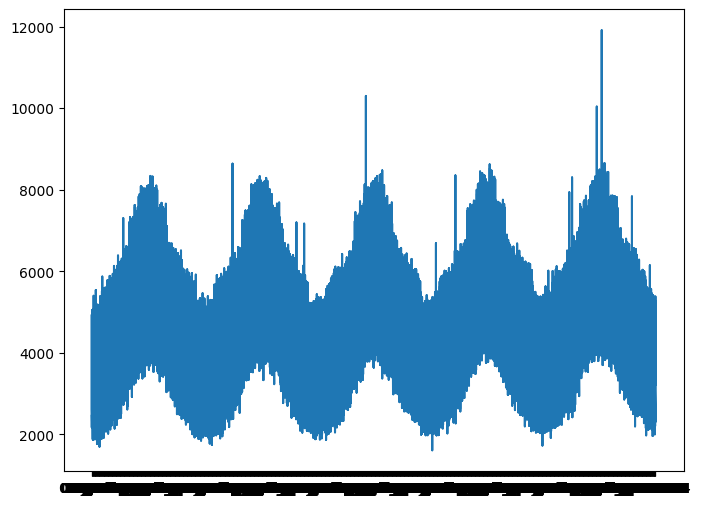

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(data['Timestamp'], data['Demand'])


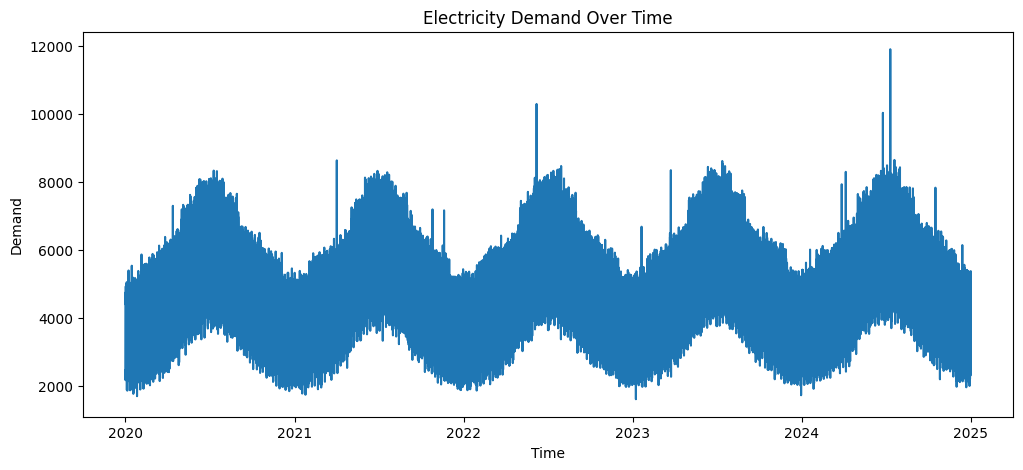

In [10]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format="%d-%b-%y")
data['datetime'] = data['Timestamp'] + pd.to_timedelta(data['hour'], unit='h')

plt.figure(figsize=(12, 5))
plt.plot(data['datetime'], data['Demand'])
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("Electricity Demand Over Time")
plt.show()


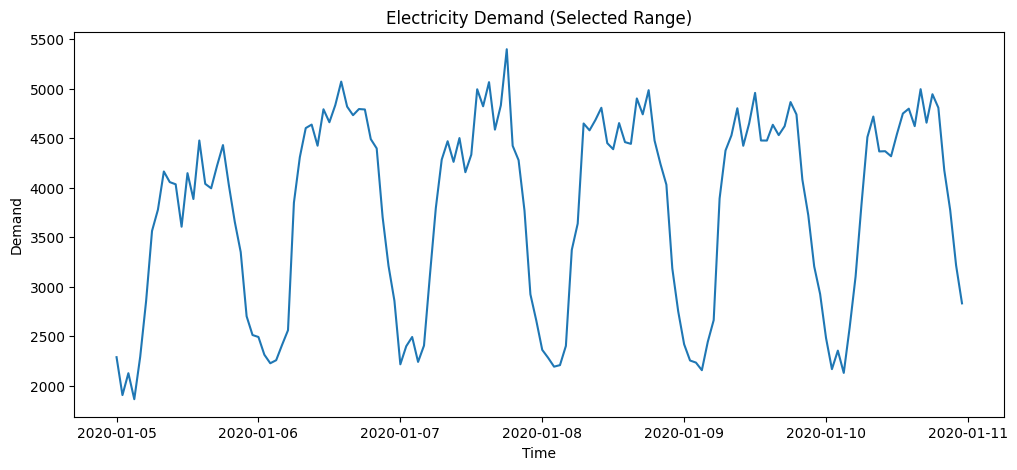

In [11]:
start = "2020-01-05 00:00:00"
end   = "2020-01-10 23:00:00"

mask = (data['datetime'] >= start) & (data['datetime'] <= end)
subset = data.loc[mask]

plt.figure(figsize=(12, 5))
plt.plot(subset['datetime'], subset['Demand'])
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("Electricity Demand (Selected Range)")
plt.show()

## **DATA PREPROCESSING**

In [12]:
print("shape of data before dropping NaN values: ", data.shape)
data = data.dropna()
print("shape of data after dropping NaN values: ", data.shape)

shape of data before dropping NaN values:  (43848, 10)
shape of data after dropping NaN values:  (43817, 10)


In [13]:
print("shape of data before dropping duplicate values: ", data.shape)
data = data.drop_duplicates()
print("shape of data after dropping duplicate values: ", data.shape)

shape of data before dropping duplicate values:  (43817, 10)
shape of data after dropping duplicate values:  (43817, 10)


In [14]:
# finding IQR
q3 = data['Demand'].quantile(0.75)
q1 = data['Demand'].quantile(0.25)
iqr = q3 - q1

print("q1: ", q1)
print("q3: ", q3)
print("IQR: ", iqr)

# winsorising data
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data['Demand_winsorized'] = data['Demand'].clip(
    lower=lower_bound,
    upper=upper_bound
)

num_winsorized = (data['Demand'] != data['Demand_winsorized']).sum()

print(f"Number of winsorized values: {num_winsorized}")

q1:  4015.44093
q3:  6000.515869
IQR:  1985.0749389999996
Number of winsorized values: 3


In [15]:
print("Min before:", data['Demand'].min())
print("Min after :", data['Demand_winsorized'].min())

print("Max before:", data['Demand'].max())
print("Max after :", data['Demand_winsorized'].max())


Min before: 1611.95402
Min after : 1611.95402
Max before: 11910.7051
Max after : 8978.1282775


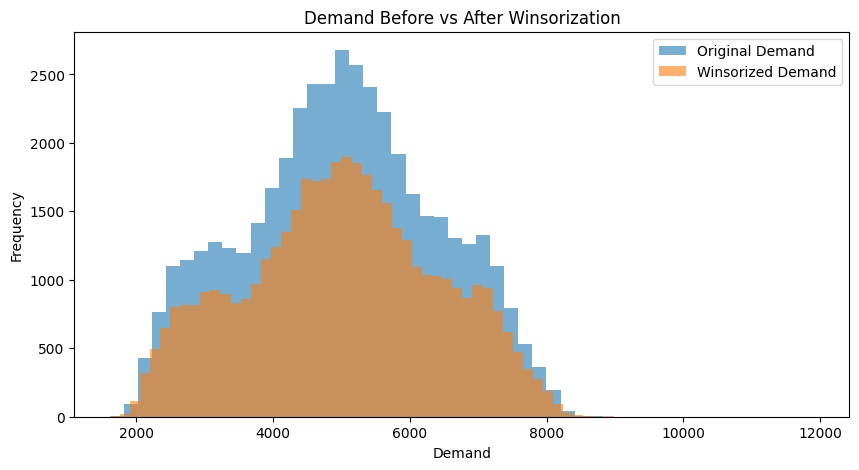

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.hist(
    data['Demand'],
    bins=50,
    alpha=0.6,
    label='Original Demand'
)

plt.hist(
    data['Demand_winsorized'],
    bins=50,
    alpha=0.6,
    label='Winsorized Demand'
)

plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.title("Demand Before vs After Winsorization")
plt.legend()
plt.show()


## **MODEL TRAINING**

In [17]:
# arima
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

In [18]:
ts = data['Demand']
result = adfuller(ts)
print('ADF Statistic: ', result[0])
print('p value: ', result[1])

if result[1] > 0.05:
    print("Series is non-stationary, differencing is needed")
else:
    print("Series is stationary, no differencing is needed")

ADF Statistic:  -6.17522482895329
p value:  6.655676456432344e-08
Series is stationary, no differencing is needed


In [ ]:
import itertools
p = [0,1,2,3]
d = [0,1,2]
q = [0,1,2,3]

pdq = list(itertools.product(p, d, q))

train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

results = []

for order in pdq:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))

        results.append((order, rmse))
        print(f"ARIMA{order} RMSE={rmse:.2f}")

    except Exception as e:
        continue


best_order, best_rmse = min(results, key=lambda x: x[1])
print("Best ARIMA:", best_order)
print("RMSE:", best_rmse)


ARIMA(0, 0, 0) RMSE=1418.34
ARIMA(0, 0, 1) RMSE=1418.34
ARIMA(0, 0, 2) RMSE=1418.33
ARIMA(0, 0, 3) RMSE=1418.33
ARIMA(0, 1, 0) RMSE=1451.59
ARIMA(0, 1, 1) RMSE=1461.42
ARIMA(0, 1, 2) RMSE=1477.86
ARIMA(0, 1, 3) RMSE=1527.93
ARIMA(0, 2, 0) RMSE=604704.54
ARIMA(0, 2, 1) RMSE=806958.83
ARIMA(0, 2, 2) RMSE=213950.06
ARIMA(0, 2, 3) RMSE=1423.64
ARIMA(1, 0, 0) RMSE=1418.14
ARIMA(1, 0, 1) RMSE=1418.19
ARIMA(1, 0, 2) RMSE=1418.23
ARIMA(1, 0, 3) RMSE=1418.24
ARIMA(1, 1, 0) RMSE=1469.76
ARIMA(1, 1, 1) RMSE=1438.31
ARIMA(1, 1, 2) RMSE=1521.29
ARIMA(1, 1, 3) RMSE=1829.63
ARIMA(1, 2, 0) RMSE=86977.00
ARIMA(1, 2, 1) RMSE=328971.59
ARIMA(1, 2, 2) RMSE=366099.85
ARIMA(1, 2, 3) RMSE=1439.90
ARIMA(2, 0, 0) RMSE=1418.28
ARIMA(2, 0, 1) RMSE=1418.36
ARIMA(2, 0, 2) RMSE=1418.36
ARIMA(2, 0, 3) RMSE=1418.36
ARIMA(2, 1, 0) RMSE=1444.51
ARIMA(2, 1, 1) RMSE=1452.70
ARIMA(2, 1, 2) RMSE=1558.36
ARIMA(2, 1, 3) RMSE=1829.40
ARIMA(2, 2, 0) RMSE=268410.98
ARIMA(2, 2, 1) RMSE=213119.62
ARIMA(2, 2, 2) RMSE=1421.44
ARIMA

: 

In [ ]:
# SARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

seasonal_period = 24

p = [0, 1, 2]
d = [0, 1]
q = [0, 1, 2]

P = [0, 1]
D = [0, 1]
Q = [0, 1]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]


sarima_results = []

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=seasonal_order + (seasonal_period,),
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            model_fit = model.fit(disp=False)

            forecast = model_fit.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test, forecast))

            sarima_results.append((order, seasonal_order, rmse))
            print(
                f"SARIMA{order}x{seasonal_order + (seasonal_period,)} "
                f"RMSE={rmse:.2f}"
            )

        except Exception:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 24) RMSE=5296.83
SARIMA(0, 0, 0)x(0, 0, 1, 24) RMSE=5293.66
SARIMA(0, 0, 0)x(0, 1, 0, 24) RMSE=1888.11


## **MODEL EVALUATION**

## **MODEL INFERENCE**